In [183]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy import interpolate
import glob
import os

def process_year(yeart):    
    montht='*'
    ROOT='/home5/pharos/REFERENCE_DATA/OCEAN_REP/CORA/CORA5.1/data/'

    path=glob.glob(os.path.join(ROOT+yeart+'/*'+yeart+montht+'15_dat_TEMP.nc'))
    #path=glob.glob(os.path.join(ROOT+yeart+'/*'+yeart+montht+'15_dat_PSAL.nc'))
    
    path.sort()
    DAT=xr.open_mfdataset(path,decode_times=False)
    DAT=DAT.where((DAT.LATITUDE>=22)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=123)&(DAT.LONGITUDE<=170),drop=True)
    #DAT=DAT.where((DAT.LATITUDE>=28)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=-79)&(DAT.LONGITUDE<=-35),drop=True)

    #REDUCE TO QC=1
    mask = (np.abs(DAT['TEMP']) != np.nan) & (DAT['TEMP_QC'] == 1.)
    #mask = (np.abs(DAT['PSAL']) != np.nan) & (DAT['PSAL_QC'] == 1.)
    DAT.coords['mask'] = (('N_PROF', 'N_LEVELS'), mask)
    DAT = DAT.where(DAT.mask, drop=True)
    DAT = DAT.drop('mask')

    #AT LEAST 10 POINTS ON PROFILE WITH MIN DEPTH =< 5m & MAX DEPHT >= 700m
    H = DAT['DEPH'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
    #H = DAT['DEPH'].where(DAT['PSAL'].notnull()).max(dim='N_LEVELS')
    G = DAT['DEPH'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
    #G = DAT['DEPH'].where(DAT['PSAL'].notnull()).min(dim='N_LEVELS')
    
    DAT = DAT.where((H>=700)&(G<=5),drop=True)
    N = DAT['TEMP'].notnull().sum('N_LEVELS')
    #N = DAT['PSAL'].notnull().sum('N_LEVELS')
    DAT = DAT.where(N>=10,drop=True) 

    #REDUCE DIMENSIONS
    DAT['A']=DAT['REFERENCE_DATE_TIME'].min(dim='N_LEVELS')
    DAT['B']=DAT['DATA_TYPE'].min(dim='N_LEVELS')
    DAT['C']=DAT['PLATFORM_NUMBER'].min(dim='N_LEVELS')
    DAT['D']=DAT['WMO_INST_TYPE'].min(dim='N_LEVELS')
    DAT['E']=DAT['DC_REFERENCE'].min(dim='N_LEVELS')
    DAT['F']=DAT['JULD'].min(dim='N_LEVELS')
    DAT['G']=DAT['LATITUDE'].min(dim='N_LEVELS')
    DAT['H']=DAT['LONGITUDE'].min(dim='N_LEVELS')
    DAT['I']=DAT['TEMP_PROC'].min(dim='N_LEVELS')
    #DAT['I']=DAT['PSAL_PROC'].min(dim='N_LEVELS')
    
    DAT=DAT.drop(['REFERENCE_DATE_TIME','DATA_TYPE','PLATFORM_NUMBER','WMO_INST_TYPE','DC_REFERENCE',
                 'JULD','LATITUDE','LONGITUDE','TEMP_PROC'])
    DAT=DAT.rename({'A':'REFERENCE_DATE_TIME','B':'DATA_TYPE','C':'PLATFORM_NUMBER',
                    'D':'WMO_INST_TYPE','E':'DC_REFERENCE','F':'JULD','G':'LATITUDE',
                    'H':'LONGITUDE','I':'TEMP_PROC'})
    #DAT=DAT.drop(['REFERENCE_DATE_TIME','DATA_TYPE','PLATFORM_NUMBER','WMO_INST_TYPE','DC_REFERENCE',
    #             'JULD','LATITUDE','LONGITUDE','PSAL_PROC'])
    #DAT=DAT.rename({'A':'REFERENCE_DATE_TIME','B':'DATA_TYPE','C':'PLATFORM_NUMBER',
    #                'D':'WMO_INST_TYPE','E':'DC_REFERENCE','F':'JULD','G':'LATITUDE',
    #                'H':'LONGITUDE','I':'PSAL_PROC'})
    
    print yeart,' : ',len(DAT.N_PROF)

    #INTERPOLATION
    #first create the interpolation model between N_LEVELS and DEPH
    xx=DAT.DEPH.min(dim='N_PROF').values
    yy=range(len(DAT.N_LEVELS))
    ft=interpolate.interp1d(xx,yy,bounds_error=False,fill_value='extrapolate')
    #now generate the new levels to interpolate on (0m to 700m)
    new_depth=np.arange(0,700,5)
    iy=ft(new_depth)
    #pre-interpolate NaN values on original depth values
    filledT=DAT.TEMP.interpolate_na(dim='N_LEVELS')
    filledTR=DAT.TEMP_RESI.interpolate_na(dim='N_LEVELS')
    #filledT=DAT.PSAL.interpolate_na(dim='N_LEVELS')
    #filledTR=DAT.PSAL_RESI.interpolate_na(dim='N_LEVELS')
    
    #Duplicate 1st value (at 5m or below) to surface
    filledT.load()
    filledT[:,0:3]=filledT[:,0:3].bfill(dim='N_LEVELS')    
    filledTR.load()
    filledTR[:,0:3]=filledTR[:,0:3].bfill(dim='N_LEVELS')    
    #xarray interpolate profiles
    TEMPi=filledT.interp(N_LEVELS=iy)
    TEMPi.load()
    TEMPi[:,0:3]=TEMPi[:,0:3].bfill(dim='N_LEVELS')  
    TEMPRi=filledTR.interp(N_LEVELS=iy)
    TEMPRi.load()
    TEMPRi[:,0:3]=TEMPRi[:,0:3].bfill(dim='N_LEVELS')      

    #create new dataset
    new_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],TEMPi.values),
                       'temp_resi':(['N_PROF','DEPTH'],TEMPRi.values),
                       'latitude':(['N_PROF'],DAT.LATITUDE.values),
                       'longitude':(['N_PROF'],DAT.LONGITUDE.values),
                       'juld':(['N_PROF'],DAT.JULD.values),
                       'reference_date_time':(['N_PROF'],DAT.REFERENCE_DATE_TIME.values),
                       'platform_number':(['N_PROF'],DAT.PLATFORM_NUMBER.values),
                       'inst_type':(['N_PROF'],DAT.WMO_INST_TYPE.values),},
                      coords={'DEPTH':new_depth})       
    
#     new_ds=xr.Dataset({'psal':(['N_PROF','DEPTH'],TEMPi.values),
#                       'psal_resi':(['N_PROF','DEPTH'],TEMPRi.values),
#                       'latitude':(['N_PROF'],DAT.LATITUDE.values),
#                       'longitude':(['N_PROF'],DAT.LONGITUDE.values),
#                       'juld':(['N_PROF'],DAT.JULD.values),
#                       'reference_date_time':(['N_PROF'],DAT.REFERENCE_DATE_TIME.values),
#                       'platform_number':(['N_PROF'],DAT.PLATFORM_NUMBER.values),
#                       'inst_type':(['N_PROF'],DAT.WMO_INST_TYPE.values),},
#                      coords={'DEPTH':new_depth})   

    #attributes
    new_ds.attrs=DAT.attrs
    new_ds.temp.attrs=DAT.TEMP.attrs
    new_ds.temp_resi.attrs=DAT.TEMP_RESI.attrs
    #new_ds.psal.attrs=DAT.PSAL.attrs
    #new_ds.psal_resi.attrs=DAT.PSAL_RESI.attrs
    
    new_ds.latitude.attrs=DAT.LATITUDE.attrs
    new_ds.longitude.attrs=DAT.LONGITUDE.attrs
    new_ds.juld.attrs=DAT.JULD.attrs
    new_ds.reference_date_time.attrs=DAT.REFERENCE_DATE_TIME.attrs
    new_ds.platform_number.attrs=DAT.PLATFORM_NUMBER.attrs
    new_ds.inst_type.attrs=DAT.WMO_INST_TYPE.attrs        

    return new_ds
    #new_ds.to_netcdf('/export/home1/DATA/PIRATE/CORA/Kuroshio/SDL_CORA_Kuroshio_TEMP_'+yeart+'.nc')
    #new_ds.to_netcdf('/export/home1/DATA/PIRATE/CORA/Kuroshio/SDL_CORA_Kuroshio_PSAL_'+yeart+'.nc')    
    

In [184]:
# for yeart in ['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000',
#              '2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011',
#              '2012','2013','2014','2015','2016']:      
this_ds=process_year('2000')

2000  :  6908


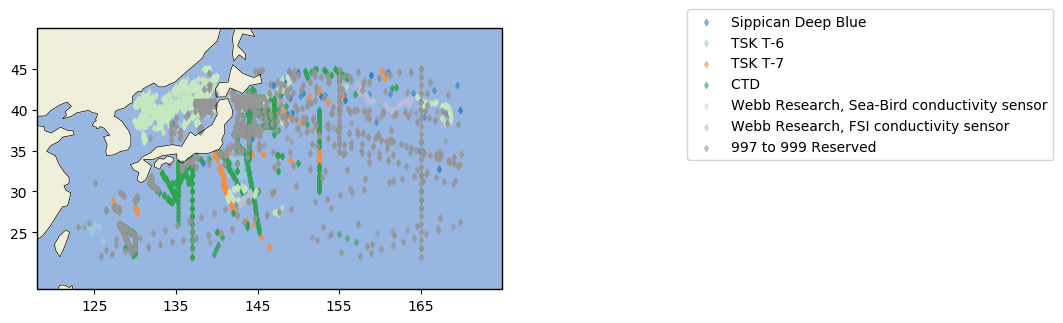

In [188]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

this_ds2=this_ds #.where(this_ds.inst_type.isin(['995 ']),drop=True)

# Set the color map to match the number of types
uniq=np.unique(this_ds2.inst_type.values)
z = range(1,len(uniq))
hot = plt.get_cmap('tab20c')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

#go search for instrument codes meaning
aaa=pd.read_csv('/home4/homedir4/perso/kbalem/wmo_codes.txt',sep=';',names=['code','name'])
uniq_names=np.array([])
for i in uniq.astype('int'):
    if(aaa['name'][aaa['code']==i].values != ''):
        uniq_names=np.append(uniq_names,aaa['name'][aaa['code']==i].values)
    else:
        uniq_names=np.append(uniq_names,'Not found')

#PLOT CLUSTERS
fig = plt.figure(dpi=100)
mproj=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=mproj)
ax.set_extent([118, 175, 18, 50], crs=mproj)
#ax.set_extent([-82, -30, 20, 50], crs=mproj)

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(125,175,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
#ax.set_xticks(range(-75,-30,10), crs=mproj)
#ax.set_yticks(range(25,50,5), crs=mproj)


# Plot each species
for i in range(len(uniq)):    
    indx = this_ds2['inst_type'] == uniq[i]
    plt.scatter(this_ds2.longitude[indx], this_ds2.latitude[indx], s=10, 
                color=scalarMap.to_rgba(i), label=uniq_names[i], marker='d',alpha=0.5)

plt.legend(bbox_to_anchor=(2.2, 1.1), loc='upper right', ncol=1)
    
plt.show()